# Preamble 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter
from importlib import reload

import funcs 
reload(funcs);

In [2]:
param1=1000

In [3]:
PRIMER_init = 5000000
class PrimeGetter:
    def __init__(self):
        self.cache = {}

    @staticmethod
    def is_prime(n):
        """
            Checks whether n is prime.
        :param n:   Value to check primality.
        :type n:    int
        :return:    False  if n is composite, otherwise
                    True   (probably prime).
        :rtype:     bool
        Notes
            May return True even though n is composite.
            Probability of such event is not greater than 1 / n**2.
        Time complexity
            O(log(n)**3)
        References
            https://en.wikipedia.org/wiki/Miller–Rabin_primality_test
        """

        if n == 2 or n == 3:
            return True
        elif n == 1 or n % 2 == 0:
            return False

        d = n - 1
        r = 0
        while d % 2 == 0:  # n - 1 = d * 2**r, d - odd
            r += 1
            d >>= 1

        for i in range(r):
            a = np.random.randint(2, n)

            x = pow(a, d, n)  # x = (a**d) % n

            if x == 1 or x == n - 1:
                continue

            stop = False
            j = 0
            while j < r - 1 and not stop:
                x = pow(x, 2, n)

                if x == 1:
                    return False
                if x == n - 1:
                    stop = True

                j += 1

            if not stop:
                return False

        return True

    def get_next_prime(self, n):
        """
            Finds smallest prime greater than n.
        :param n:   Lower bound of value of prime.
        :type n:    int
        :return:    Prime p >= n.
        :rtype:     int
        Time complexity
            O(log(n)**4)
        """

        if n in self.cache:
            return self.cache[n]

        p = n + 1
        if p % 2 == 0:
            p += 1

        while not self.is_prime(p):
            p += 2

        self.cache[n] = p
        return p


In [4]:
def k_independent_function_vectorized(k, s1, s2, r, m=2):
    '''
    Returns the s1*s2 hashing results generated by k-independent hashing. 
    The iteration is fine because k is typically less than 5. 

    :param k: int
    :param s1: dimension 1
    :param s2: dimension 2
    :param r: int RANGE. size of self.frequency vector = |U|
    :param m: number of buckets
    :return: a matrix of size (s1 * s2 * range) with values of {-1, 1}
    '''

    prime_getter = PrimeGetter()
    p_offset = PRIMER_init

    p = np.zeros((s1, s2, 1))

    for i in range(s1):
        for j in range(s2):
            p[i, j] = prime_getter.get_next_prime(p_offset)
            p_offset += 1

    params = np.round(np.random.random(size=(s1, s2, k)) * p).astype(int)

    hashing_input = range(r)

    res = np.zeros((s1, s2, r))
    pow_x = np.ones((s1, s2, r))

    for i in range(k):
        res = (res + pow_x * params[:, :, i:i+1]) % p
        pow_x = (pow_x * hashing_input) % p
    hashed = (res % 2) * 2 - 1
    return hashed

# Example 

In [5]:
#Size of data stream
m = param1*100
#the k of F_k
k = 2
#two user defined parameters lambda and eplison, so that Pr(|Y-F_k|>lambda F_k) < eplison
lambd = 0.2
eplison = 0.2

In [6]:
def stream_distribution(mode,m, param1=0,param2=0):
    mode = mode.lower()

    #low is always 0 
    #param1 is highest value in uniform. 
    if mode=="uniform":
        np.random.seed(0)
        return np.random.randint(low=0, high=param1, size=m)

    #param1 is zipf coefficient. 
    if mode=="zipf":
        return np.random.zipf(param1, m)

    #param1 is mean 
    #param2 is std. 
    if mode=="gaussian":
        return (np.floor(np.random.normal(loc=param1, scale=param2, size=m))).astype("int")

In [7]:
#define a stream
a = stream_distribution("uniform", m, par1,20)

In [8]:
#compute the ground truth
a_counter = Counter(a)
frequency_vector = np.array([a_counter[i] for i in sorted(list(a_counter))])
ground_truth = np.sum(frequency_vector**2)

#the size of N
n = frequency_vector.shape[0]

In [9]:
class AMS_offline(object):
    '''
    AMS Sketch for offline learning. We precompute the frequency vector of the data
    stream. Online update is not implemented yet.
    '''

    def __init__(self, stream, lambd, epsilon, j):
        '''
        Build frequency vector
        :param stream: list of non-negative integer in range(0, RANGE)
        :param hash_generator: function that when call returns a hash function of the desired type. e.g.
        :param j: j-indepedent hash function
        >>> hash_generator = lambda k: poly_hash(k);
        '''

        counter = Counter(stream)
        self.frequency_vector = np.array([counter[i] for i in sorted(list(counter))])

        self.F_1 = np.sum(self.frequency_vector)
        
        #compute s1 and s2 as in the paper
        self.s1 = int(np.ceil(1*k*n**(1-1/k)/lambd**2))
        self.s2 = int(np.ceil(2*np.log(1/epsilon)))
#         print(self.s1,self.s2)
        self.j = j
        self.lambd = lambd
        self.epsilon = epsilon
        
        self.stream = stream
#         self.hash_generator = hash_generator
        

        
    def estimate_F2(self):
        '''
        Implement the improved estimation of F2 with matrix multiplication.
        Uniformly random hashing is used in place of the four-independent hashing
        This is not exactly the same as in the original paper, but is the most popular
        way for implementation nowadays
        :return: estimated F_2
        '''
        self.s1 = int(np.ceil(16/(self.lambd**2)))
        self.s2 = int(np.ceil(2*np.log(1/self.epsilon)))
#         print(self.s1,self.s2)
        if self.j == 0:
            self.hashing_matrix = np.random.choice(a = [1, -1], size=(self.s1, self.s2, n), replace=True)
        else:
            self.hashing_matrix = k_independent_function_vectorized(self.j, self.s1, self.s2, n, m=2)
        Z = np.matmul(self.hashing_matrix, self.frequency_vector)
        X = np.square(Z)
        Y = np.mean(X, axis=0)
        estimation = np.median(Y)

        return estimation


    def estimate_Fk(self, k):
        '''
        Implement the estimation of Fk
        :return: estimated Fk
        '''
        self.X = np.zeros((self.s1, self.s2))

        prob = self.frequency_vector / self.F_1

        for i in range(self.s1):
            for j in range(self.s2):
                idx = np.random.choice(a=n, size=1, p=prob)[0]
                r = np.random.randint(low=1, high=self.frequency_vector[idx], size=1)[0]
                self.X[i][j] = self.F_1 * (r**k - (r - 1)**k)

        Y = np.mean(self.X, axis=0)
        estimation = np.median(Y)
        
        return estimation
    
    def estimate_Fk_vectorized(self, k):
        
        prob = self.frequency_vector / self.F_1
        idx = np.random.choice(a=n, size=(self.s1, self.s2), p=prob)

        onehot_idx = np.eye(n)[idx]
        freq = np.matmul(onehot_idx, self.frequency_vector)
        offset = np.random.random(size=(self.s1, self.s2))
        r = np.round((freq - 1) * offset) + 1


        X = (np.power(r, k) - np.power(r-1, k)) * self.F_1
        Y = np.mean(X, axis=0)
        estimation = np.median(Y)
        
        return estimation
    
    def estimate_Fk_online(self, k):
        
        self.X = np.zeros((self.s1, self.s2))
        
        a = np.ones((self.s1, self.s2))*self.stream[0]
        r = np.ones((self.s1, self.s2))
        
        for i in np.linspace(1,m-1,m-1):
            i = int(i)
            
            r = r + (a == self.stream[i])
            
            rd = np.random.uniform(size=(self.s1, self.s2))
            replace = rd < 1/(i+1)
            remain = rd >= 1/(i+1)
            
            a = (a * remain) + (replace * self.stream[i])
            r = (r * remain) + (replace * 1)
            
        self.X = (np.power(r, k) - np.power(r-1, k)) * self.F_1
            

        Y = np.mean(self.X, axis=0)
        estimation = np.median(Y)
        
        return estimation

In [10]:
# time1 = time.time()
# AMS1 = A.estimate_F2()
# time2 = time.time()
# # AMS2 = A.estimate_Fk(2)
# time3 = time.time()
# AMS3 = A.estimate_Fk_vectorized(k)
# time4 = time.time()
# # AMS4 = A.estimate_Fk_online(k)
# # time5 = time.time()

# print("The ground true value is:",ground_truth)
# print("F_2 function return AMS sketch:",AMS1.astype("float32"), "using",(time2-time1),"second")
# # print("F_k function return AMS sketch:",AMS2.astype("float32"), "using",(time3-time2),"second")
# print("Offline F_k Vec function return AMS sketch:",AMS3.astype("float32"), "using",(time4-time3),"second")
# # print("Online F_k Vec function return AMS sketch:",AMS4.astype("float32"), "using",(time5-time4),"second")

In [11]:
# ###check if the result meet the accuracy
# print("The F_2 function return meet the accuracy:", np.abs(AMS1-ground_truth)<lambd*ground_truth,". With error",np.abs(AMS1-ground_truth)/ground_truth)
# # print("The F_k function return meet the accuracy:", np.abs(AMS2-ground_true)<lambd*ground_true,". With error",np.abs(AMS2-ground_true)/ground_true)
# print("The Offline F_k function return meet the accuracy:", np.abs(AMS3-ground_truth)<lambd*ground_truth,". With error",np.abs(AMS3-ground_truth)/ground_truth)
# # print("The Online F_k function return meet the accuracy:", np.abs(AMS4-ground_truth)<lambd*ground_truth,". With error",np.abs(AMS4-ground_truth)/ground_truth)

In [12]:
# # A sanity check for k-independent hashing
# hashed = funcs.k_independent_function_vectorized(k=3, s1=1600, s2=10, r=100)
# print('hashed value should be {-1, 1}: ', np.unique(hashed))
# print('hashed value should almost sum to 0: ',np.sum(hashed))
# print('Total number of elements -- compared to the previous value: ', 1600*10*100)

# Experiments 

In [37]:
j=5
A = AMS_offline(a, lambd, eplison, j)

## Experiment 1 

In [38]:
# time_record = np.zeros((100,1))
# error_record = np.zeros((100,1))

# for i in range(100):
#     if i%10==0:
#         print(i)
#     time1 = time.time()
#     AMS1 = A.estimate_F2()
#     time2 = time.time()
#     time_record[i] =  time2-time1
#     error_record[i] = np.abs(AMS1-ground_truth)/ground_truth


# print("F_2 function return AMS sketch:",AMS1.astype("float32"), "using",(time2-time1),"second")
# print("The F_2 function return meet the accuracy:", np.abs(AMS1-ground_truth)<lambd*ground_truth,". With error",np.abs(AMS1-ground_truth)/ground_truth)
# np.savetxt('error'+str(param1)+'.txt', error_record)
# np.savetxt('time'+str(param1)+'.txt', time_record)
# plt.plot(error_record,'.')

In [39]:
# ranges=[10,100,1000,8000,10000,20000,30000,50000,80000,100000]
# error = [0,0,0,0,0,0,0,0,0,0]
# k=0
# for i in ranges:
#     error[k]=np.mean(np.loadtxt('error'+str(i)+'.txt'))
#     k=k+1
# print(error)
# plt.semilogx(ranges,error,'--')

In [40]:
# plt.hist(a, bins=100);

## Experiment 2 

0
10
20
30
40
50
60
70
80
90
F_2 function return AMS sketch: 10493706.0 using 2.139204263687134 second
The F_2 function return meet the accuracy: True . With error 0.03915510878755304


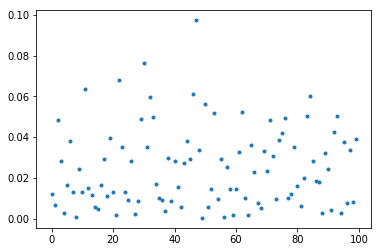

In [41]:
# time_record = np.zeros((100,1))
# error_record = np.zeros((100,1))

# for i in range(100):
#     if i%10==0:
#         print(i)
#     time1 = time.time()
#     AMS1 = A.estimate_F2()
#     time2 = time.time()
#     time_record[i] =  time2-time1
#     error_record[i] = np.abs(AMS1-ground_truth)/ground_truth


# print("F_2 function return AMS sketch:",AMS1.astype("float32"), "using",(time2-time1),"second")
# print("The F_2 function return meet the accuracy:", np.abs(AMS1-ground_truth)<lambd*ground_truth,". With error",np.abs(AMS1-ground_truth)/ground_truth)
# np.savetxt('error'+str(j)+'.txt', error_record)
# np.savetxt('time'+str(j)+'.txt', time_record)
# plt.plot(error_record,'.')

In [42]:
print(np.mean(error_record))

0.024979265804581482


## Experiment 3 

## Experiment 4